In [1]:
# %%capture --no-stderr
#%pip install --quiet -U pandas matplotlib sqlite_dataset langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [2]:
import os
import getpass
from dotenv import load_dotenv

# Carica le variabili dal file .env
load_dotenv()

True

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("AZURE_OPENAI_API_KEY")
_set_env("GPT_URL")

# Tools

In [4]:
from langchain_core.tools import StructuredTool
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from typing import Union, Dict, List, Any
from pydantic import BaseModel, Field

class PlotArgs(BaseModel):
    """Arguments for the plot_data function"""
    df: Dict[str, List[Any]] = Field(
        ..., 
        description="Dictionary containing the data to plot, will be converted to DataFrame"
    )
    code: str = Field(
        ..., 
        description="Python code string that uses 'df' to create the plot"
    )
    
    class Config:
        arbitrary_types_allowed = True

def _plot_data(
    df: Dict[str, List[Any]],
    code: str
) -> str:
    """Executes plotting code on a DataFrame."""
    plt.figure()
    img_bytes = BytesIO()
    
    try:
        # Convert dict to DataFrame
        df = pd.DataFrame(df)
            
        # Create a clean namespace for execution
        namespace = {
            'df': df,
            'plt': plt,
            'pd': pd
        }
        
        # Execute the provided code
        exec(code, namespace)
        
    except Exception as e:
        #plt.close()
        return f"Failed to execute. Error: {repr(e)}"
        
    return "\n\nIf you have completed all tasks, respond with FINAL ANSWER."

# Create the structured tool
plot_data_tool = StructuredTool(
    name="plot_data",
    description="""Create plots from data. 
    Required Arguments:
        - df: A dictionary with lists as values that will be converted to a DataFrame
        - code: A string containing Python plotting code that uses 'df' as the DataFrame name. code must include 
            - create that plot
            - save the image in temp_plot.png
            - close the plot
    
    Example usage:
        plot_data(
            df={
                'category': ['A', 'B', 'C'],
                'values': [1, 2, 3]
            },
            code='''
                plt.figure(figsize=(10, 6))
                plt.bar(df['category'], df['values'])
                plt.title('My Plot')
                plt.xlabel('Category')
                plt.ylabel('Values')
                plt.tight_layout()
                img_path = 'temp_plot.png'
                plt.savefig(img_path, format='png', bbox_inches='tight', dpi=300)
                plt.close()
            '''
        )
    """,
    func=_plot_data,
    args_schema=PlotArgs
)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from langchain_core.tools import Tool
import sqlite3
from typing import Optional, Any, Union, Dict, List

def _retrieve_data(query: str) -> pd.DataFrame:
    """Execute a SQL query on the SQLite database and return the result as a pandas DataFrame."""
    conn = sqlite3.connect('sales_dataset.db')
    
    try:
        df = pd.read_sql_query(query, conn)
    except Exception as e:
        print(f"An error occurred: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    
    return df


def _get_schema_info(*args: Any, **kwargs: Any)-> dict:
    """Get database schema information including tables, columns, and sample values."""
    conn = sqlite3.connect('sales_dataset.db')
    cursor = conn.cursor()
    
    schema_info = {}
    
    # Get list of tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    for table in tables:
        table_name = table[0]
        schema_info[table_name] = {
            'columns': [],
            'sample_values': {}
        }
        
        # Get column info
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        schema_info[table_name]['columns'] = [
            {
                'name': col[1],
                'type': col[2],
                'nullable': not col[3],
                'primary_key': bool(col[5])
            }
            for col in columns
        ]
        
        # Get sample distinct values for each column (limited to 5)
        for col in columns:
            cursor.execute(f"SELECT DISTINCT {col[1]} FROM {table_name} LIMIT 5;")
            sample_values = cursor.fetchall()
            schema_info[table_name]['sample_values'][col[1]] = [str(val[0]) for val in sample_values]
    
    conn.close()
    return schema_info

def _get_column_stats(table_name: str, column_name: str) -> dict:
    """Get statistical information about a specific column."""
    conn = sqlite3.connect('sales_dataset.db')
    
    try:
        # Basic statistics
        df = pd.read_sql_query(f"""
            SELECT 
                COUNT(*) as count,
                COUNT(DISTINCT {column_name}) as unique_values,
                MIN({column_name}) as min_value,
                MAX({column_name}) as max_value
            FROM {table_name}
            WHERE {column_name} IS NOT NULL
        """, conn)
        
        stats = df.to_dict(orient='records')[0]
        
        # Add value distribution
        df_dist = pd.read_sql_query(f"""
            SELECT {column_name}, COUNT(*) as frequency
            FROM {table_name}
            WHERE {column_name} IS NOT NULL
            GROUP BY {column_name}
            ORDER BY frequency DESC
            LIMIT 5
        """, conn)
        
        stats['top_values'] = df_dist.to_dict(orient='records')
        
    except Exception as e:
        stats = {'error': str(e)}
    finally:
        conn.close()
    
    return stats

# Create the tools
schema_info_tool = Tool(
    name="get_schema_info",
    description="""Returns complete database schema information with no required parameters. 
    Automatically retrieves all tables, their columns, data types, and sample values. 
    No input arguments needed - just call the tool directly.""",
    func=_get_schema_info
)

column_stats_tool = Tool(
    name="get_column_stats",
    description="Get statistical information about a specific column including count, unique values, min/max, and value distribution. Args: table_name (str), column_name (str)",
    func=_get_column_stats
)
# Create the tools using the Tool class
retrieve_data_tool = Tool(
    name="retrieve_data",
    description="Execute a SQL query on the SQLite database and return results as a DataFrame. Args: query (str): The SQL query to execute. Returns: pd.DataFrame containing query results.",
    func=_retrieve_data
)


# Model

In [6]:
from langchain_openai import AzureChatOpenAI

tools = [schema_info_tool, column_stats_tool, retrieve_data_tool, plot_data_tool]

llm = AzureChatOpenAI(
    temperature=0,
    api_version="2024-08-01-preview",
    azure_endpoint=os.environ['GPT_URL'],
    azure_deployment="gpt-4o")

llm_with_tools = llm.bind_tools(tools)

# Memory DB

In [7]:
# # pull file if it doesn't exist and connect to local db
# !mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

In [8]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

# Agent message

In [9]:
### FUNZIONANTE

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage 

# System message assistant
sys_msg = SystemMessage(content="""You are a data analyst assistant. 
You will be asked to answer user's requests using the data from a database. 

Before executing SQL queries:

1. To understand the database structure:
   - Call get_schema_info with no parameters
   - This will return all tables and columns information automatically

2. For detailed column analysis:
   - Use get_column_stats with (table_name, column_name) parameters
   - This helps understand the data distribution

3. For data retrieval:
   - Use retrieve_data with your SQL query
   - Make sure queries match the schema structure

4. When using the plot_data tool, you must provide two named arguments:
    1. df: Your DataFrame or dictionary containing the data
    2. code: A string containing the plotting code that goes from chart generation to plot saving

    For example:
    ```python
    plot_data(
        df={
            'column1': ['A', 'B', 'C'],
            'column2': [1, 2, 3]
        },
        code='''
            plt.figure(figsize=(10, 6))
            plt.bar(df['column1'], df['column2'])
            plt.title('My Plot')
            plt.xlabel('X Label')
            plt.ylabel('Y Label')
            plt.tight_layout()
            img_path = 'temp_plot.png'
            plt.savefig(img_path, format='png', bbox_inches='tight', dpi=300)
            plt.close()
        '''
    )
        ```
If you have created a plot return a comment to the data, this comment must help the user to understand trends/min/max/outliers, so must help interpret data.
Return alse the query generated to retrieve the data.
Remember: get_schema_info requires NO parameters - just call it directly.
""")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
    


# Graph

In [10]:
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)  


## Show

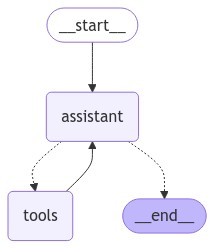

In [11]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# RUN

In [12]:
sales = pd.read_csv('data/supermarket_sales.csv')


In [13]:
# Input
initial_input = {"messages": HumanMessage(content="What is the average total price spent?")}

# Thread
thread = {"configurable": {"thread_id": "1"}}


for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is the average total price spent?
================================== Ai Message ==================================
Tool Calls:
  get_schema_info (call_h4vSnhAYR36ZFDibvRpAfhXv)
 Call ID: call_h4vSnhAYR36ZFDibvRpAfhXv
  Args:
    __arg1:
================================= Tool Message =================================
Name: get_schema_info

{"sales": {"columns": [{"name": "invoice_id", "type": "TEXT", "nullable": true, "primary_key": false}, {"name": "branch", "type": "TEXT", "nullable": true, "primary_key": false}, {"name": "city", "type": "TEXT", "nullable": true, "primary_key": false}, {"name": "customer_type", "type": "TEXT", "nullable": true, "primary_key": false}, {"name": "gender", "type": "TEXT", "nullable": true, "primary_key": false}, {"name": "product_line", "type": "TEXT", "nullable": true, "primary_key": false}, {"name": "unit_price", "type": "REAL", "nullable": true, "primary_key": false}

In [14]:
sales.Total.mean()

322.966749

In [15]:
initial_input = {"messages": HumanMessage(content="What is the average quantity ordered per product line?")}
# Thread
thread = {"configurable": {"thread_id": "1"}}
events = graph.stream(initial_input, thread, stream_mode="values")

last_message = None
for s in events:
    last_message = s
   

last_message['messages'][-1].pretty_print()

================================== Ai Message ==================================

The average quantity ordered per product line is as follows:

- **Electronic accessories**: 5.71
- **Fashion accessories**: 5.07
- **Food and beverages**: 5.47
- **Health and beauty**: 5.62
- **Home and lifestyle**: 5.69
- **Sports and travel**: 5.54

Query used:
```sql
SELECT product_line, AVG(quantity) as average_quantity FROM sales GROUP BY product_line
```


In [16]:
a = sales[['Quantity', 'Product line']].groupby(['Product line']).mean().reset_index().sort_values(by=['Quantity'], ascending=False)
a

,Product line,Quantity
0,Electronic accessories,5.711765
4,Home and lifestyle,5.693750
3,Health and beauty,5.618421
5,Sports and travel,5.542169
2,Food and beverages,5.471264
1,Fashion accessories,5.067416


In [17]:
# Input
initial_input = {"messages": HumanMessage(content="What is the most ordered product per gender?")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

events = graph.stream(initial_input, thread, stream_mode="values")
last_message = None
for s in events:
    last_message = s
   

last_message['messages'][-1].pretty_print()

================================== Ai Message ==================================

The most ordered product per gender is as follows:

- **Female**: Fashion accessories (530 units)
- **Male**: Health and beauty (511 units)

Query used:
```sql
SELECT gender, product_line, SUM(quantity) as total_quantity FROM sales GROUP BY gender, product_line ORDER BY gender, total_quantity DESC
```


In [18]:
a = sales[['Quantity', 'Gender', 'Product line']].groupby(['Gender', 'Product line']).sum().reset_index().sort_values(by=['Gender','Quantity'], ascending=False)

In [19]:
a

,Gender,Product line,Quantity
9,Male,Health and beauty,511
6,Male,Electronic accessories,483
8,Male,Food and beverages,438
11,Male,Sports and travel,424
10,Male,Home and lifestyle,413
7,Male,Fashion accessories,372
1,Female,Fashion accessories,530
2,Female,Food and beverages,514
4,Female,Home and lifestyle,498
5,Female,Sports and travel,496


================================== Ai Message ==================================

The bar chart above shows the average total price per product line. 

- **Home and lifestyle** has the highest average total price.
- **Fashion accessories** has the lowest average total price.

Query used:
```sql
SELECT product_line, AVG(total) as average_total_price FROM sales GROUP BY product_line
```

The chart provides a clear visual comparison of the average total prices across different product lines.


<Figure size 640x480 with 0 Axes>

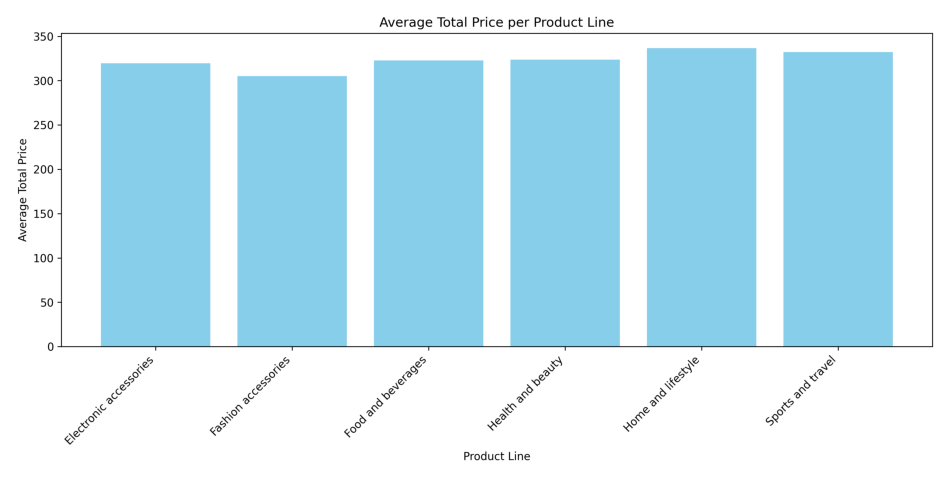

In [20]:
# Input
initial_input = {"messages": HumanMessage(content="Plotta in un grafico il total price medio per tipo di prodotto")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

events = graph.stream(initial_input, thread, stream_mode="values")
last_message = None
for s in events:
    last_message = s
   

last_message['messages'][-1].pretty_print()


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_path = "temp_plot.png"
img = mpimg.imread(img_path)

plt.figure(figsize=(12, 8))  
plt.imshow(img)
plt.axis('off')  
plt.show()

================================== Ai Message ==================================

The bar chart above shows the average total price per product line with the bars colored in red.

- **Home and lifestyle** has the highest average total price.
- **Fashion accessories** has the lowest average total price.

Query used:
```sql
SELECT product_line, AVG(total) as average_total_price FROM sales GROUP BY product_line
```

The chart provides a clear visual comparison of the average total prices across different product lines.


<Figure size 640x480 with 0 Axes>

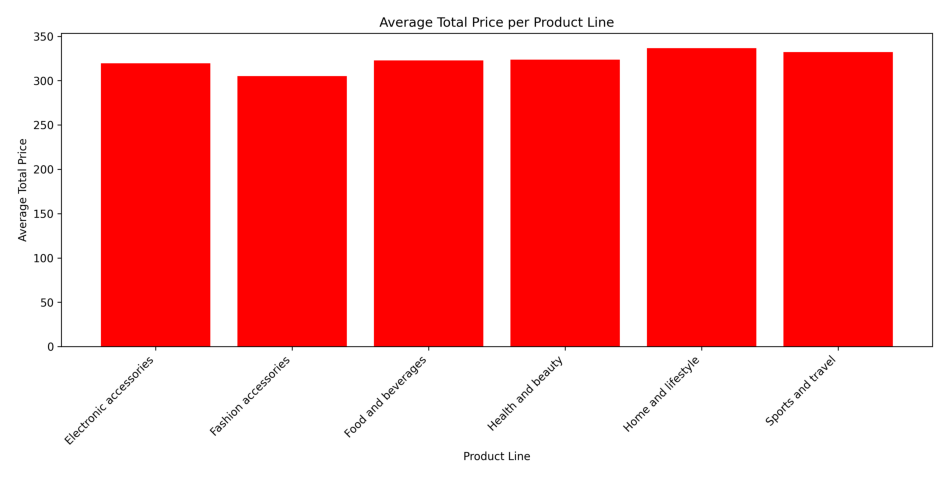

In [21]:
# Input
initial_input = {"messages": HumanMessage(content="modifica il colore di grafico, fallo rosso")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

events = graph.stream(initial_input, thread, stream_mode="values")
last_message = None
for s in events:
    last_message = s
   

last_message['messages'][-1].pretty_print()


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_path = "temp_plot.png"
img = mpimg.imread(img_path)

plt.figure(figsize=(12, 8)); 
plt.imshow(img)
plt.axis('off')  
plt.show()

================================== Ai Message ==================================

The bar chart above shows the average total price per product line and gender.

- **Home and lifestyle** has the highest average total price for females.
- **Health and beauty** has the highest average total price for males.
- **Fashion accessories** has the lowest average total price for both genders.

Query used:
```sql
SELECT product_line, gender, AVG(total) as average_total_price FROM sales GROUP BY product_line, gender
```

The chart provides a clear visual comparison of the average total prices across different product lines and genders.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

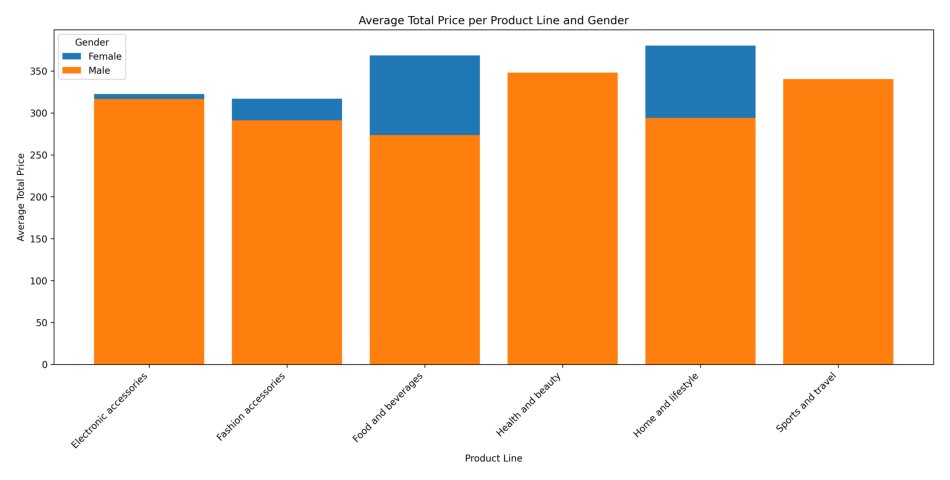

In [22]:
# Input
initial_input = {"messages": HumanMessage(content="Plotta in un grafico il total price medio per tipo di prodotto e per genere")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

events = graph.stream(initial_input, thread, stream_mode="values")
last_message = None
for s in events:
    last_message = s
   

last_message['messages'][-1].pretty_print()


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_path = "temp_plot.png"
img = mpimg.imread(img_path)

plt.figure(figsize=(12, 8)); 
plt.imshow(img)
plt.axis('off')  
plt.show()

In [23]:
a = sales[['Total', 'Gender', 'Product line']].groupby(['Gender', 'Product line']).agg({'Total':'mean'}).reset_index().sort_values(by=['Product line'])

In [24]:
a

,Gender,Product line,Total
0,Female,Electronic accessories,322.643125
6,Male,Electronic accessories,316.691965
1,Female,Fashion accessories,317.056250
7,Male,Fashion accessories,291.079207
2,Female,Food and beverages,368.565750
8,Male,Food and beverages,273.499125
3,Female,Health and beauty,290.015414
9,Male,Health and beauty,348.099460
4,Female,Home and lifestyle,380.213639
10,Male,Home and lifestyle,294.136241
